# IMPORTS

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# FUNCTIONS

In [2]:

def plot_training_curves(epochs_range, train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


# CUSTOM RA DATASET

In [3]:

class RA_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        
        # Get list of classes (severity levels)
        self.classes = sorted(os.listdir(root_dir))
        print(self.classes)

        self.image_paths = []
        self.labels = []
        
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]



# TRANSFROM COMPOSE + AUGMENTATION

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  #  ResNet 224x224 defult for images
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ColorJitter(brightness=(0.8, 1),  # Only negative brightness
                           contrast=(1, 1.2),    # Only positive contrast
                           saturation=(1, 1.2)), # Only positive saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cuda


# DATALOADERS

In [17]:
train_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
test_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
val_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'

train_dataset = RA_Dataset(train_dir, transform=train_transform)
test_dataset = RA_Dataset(test_dir, transform=test_transform)
val_dataset = RA_Dataset(val_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset information
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']
Number of training images: 5778
Number of test images: 1656
Classes: ['0', '1', '2', '3', '4']


# VISUAL

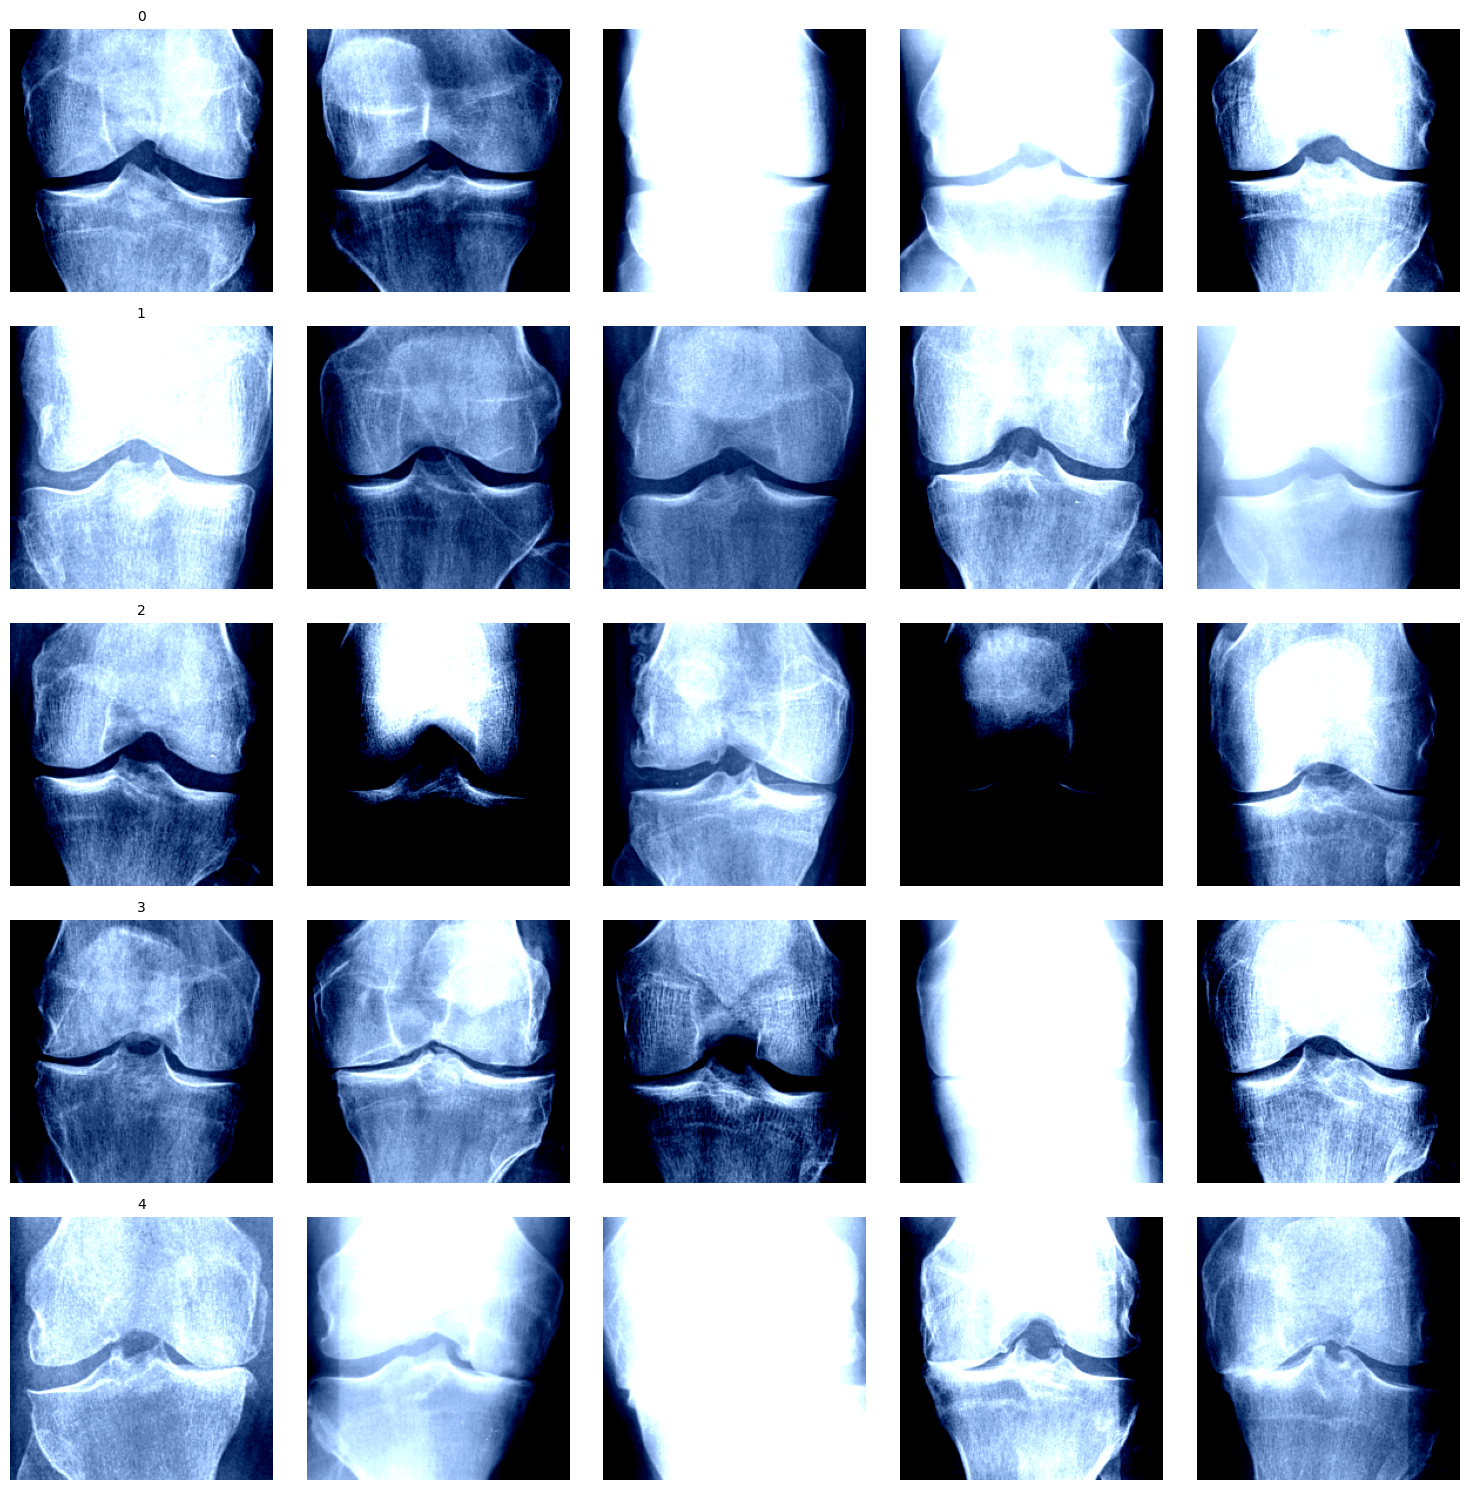

In [18]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Helper function to plot images
def plot_images_per_class(dataset, classes, n_images=5):
    class_images = {class_name: [] for class_name in classes}

    # Collect images for each class
    for img, label in dataset:
        class_name = dataset.classes[label]
        if len(class_images[class_name]) < n_images:
            class_images[class_name].append(img)

        # Stop if we've collected enough images for all classes
        if all(len(images) == n_images for images in class_images.values()):
            break

    # Plotting the images
    fig, axes = plt.subplots(len(classes), n_images, figsize=(15, len(classes) * 3))
    for idx, class_name in enumerate(classes):
        for j, img in enumerate(class_images[class_name]):
            ax = axes[idx, j]
            ax.imshow(img.permute(1, 2, 0))  # Convert from Tensor to NumPy format
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, fontsize=10)

    plt.tight_layout()
    plt.show()

# Visualize images
plot_images_per_class(train_dataset, train_dataset.classes, n_images=5)


# MODEL PICK + Classifier HEAD CHANGE

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model.fc = nn.Sequential(nn.Dropout(0.2),nn.Linear(model.fc.in_features, len(train_dataset.classes)))

In [ ]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(train_dataset.classes))
model.classifier = nn.Sequential(nn.Dropout(0.2),nn.Linear(model.classifier.in_features, len(train_dataset.classes)))

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3x224x224 -> Output: 32x224x224
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Input: 32x224x224 -> Output: 64x112x112
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # Input: 64x112x112 -> Output: 128x56x56

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves dimensions
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Adjust dimensions based on image size
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)



In [20]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TRAINING LOOP

Epoch 1/30: 100%|██████████| 181/181 [00:15<00:00, 11.60batch/s, Loss=1.4739, Accuracy=37.90%]


Epoch [1/30]
Train Loss: 1.4676, Train Accuracy: 37.90%
Validation Loss: 1.4012, Validation Accuracy: 40.31%


Epoch 2/30: 100%|██████████| 181/181 [00:15<00:00, 11.87batch/s, Loss=1.3853, Accuracy=40.81%]


Epoch [2/30]
Train Loss: 1.3974, Train Accuracy: 40.81%
Validation Loss: 1.4001, Validation Accuracy: 37.41%


Epoch 3/30: 100%|██████████| 181/181 [00:14<00:00, 12.42batch/s, Loss=1.3524, Accuracy=41.23%]


Epoch [3/30]
Train Loss: 1.3776, Train Accuracy: 41.23%
Validation Loss: 1.3651, Validation Accuracy: 41.04%


Epoch 4/30: 100%|██████████| 181/181 [00:15<00:00, 11.84batch/s, Loss=1.4912, Accuracy=42.73%]


Epoch [4/30]
Train Loss: 1.3319, Train Accuracy: 42.73%
Validation Loss: 1.3287, Validation Accuracy: 40.80%


Epoch 5/30: 100%|██████████| 181/181 [00:14<00:00, 12.25batch/s, Loss=1.2522, Accuracy=44.43%]


Epoch [5/30]
Train Loss: 1.2701, Train Accuracy: 44.43%
Validation Loss: 1.2171, Validation Accuracy: 46.49%


Epoch 6/30: 100%|██████████| 181/181 [00:15<00:00, 11.68batch/s, Loss=1.0807, Accuracy=47.58%]


Epoch [6/30]
Train Loss: 1.2114, Train Accuracy: 47.58%
Validation Loss: 1.1946, Validation Accuracy: 48.79%


Epoch 7/30: 100%|██████████| 181/181 [00:14<00:00, 12.38batch/s, Loss=1.0721, Accuracy=50.48%]


Epoch [7/30]
Train Loss: 1.1577, Train Accuracy: 50.48%
Validation Loss: 1.1503, Validation Accuracy: 51.45%


Epoch 8/30: 100%|██████████| 181/181 [00:15<00:00, 11.95batch/s, Loss=0.9301, Accuracy=52.47%]


Epoch [8/30]
Train Loss: 1.1127, Train Accuracy: 52.47%
Validation Loss: 1.1477, Validation Accuracy: 49.88%


Epoch 9/30: 100%|██████████| 181/181 [00:14<00:00, 12.35batch/s, Loss=1.2439, Accuracy=54.48%]


Epoch [9/30]
Train Loss: 1.0571, Train Accuracy: 54.48%
Validation Loss: 1.0910, Validation Accuracy: 55.45%


Epoch 10/30: 100%|██████████| 181/181 [00:15<00:00, 11.74batch/s, Loss=0.5643, Accuracy=56.11%]


Epoch [10/30]
Train Loss: 1.0299, Train Accuracy: 56.11%
Validation Loss: 1.0965, Validation Accuracy: 55.81%


Epoch 11/30: 100%|██████████| 181/181 [00:14<00:00, 12.70batch/s, Loss=1.2574, Accuracy=57.15%]


Epoch [11/30]
Train Loss: 1.0018, Train Accuracy: 57.15%
Validation Loss: 1.0789, Validation Accuracy: 55.21%


Epoch 12/30: 100%|██████████| 181/181 [00:14<00:00, 12.53batch/s, Loss=1.1242, Accuracy=58.98%]


Epoch [12/30]
Train Loss: 0.9718, Train Accuracy: 58.98%
Validation Loss: 1.1061, Validation Accuracy: 53.63%


Epoch 13/30: 100%|██████████| 181/181 [00:14<00:00, 12.41batch/s, Loss=1.0140, Accuracy=59.92%]


Epoch [13/30]
Train Loss: 0.9359, Train Accuracy: 59.92%
Validation Loss: 1.0632, Validation Accuracy: 56.66%


Epoch 14/30: 100%|██████████| 181/181 [00:14<00:00, 12.37batch/s, Loss=0.9336, Accuracy=61.27%]


Epoch [14/30]
Train Loss: 0.9142, Train Accuracy: 61.27%
Validation Loss: 1.0828, Validation Accuracy: 56.17%


Epoch 15/30: 100%|██████████| 181/181 [00:14<00:00, 12.65batch/s, Loss=0.8040, Accuracy=63.38%]


Epoch [15/30]
Train Loss: 0.8728, Train Accuracy: 63.38%
Validation Loss: 1.0568, Validation Accuracy: 57.99%


Epoch 16/30: 100%|██████████| 181/181 [00:14<00:00, 12.24batch/s, Loss=0.7065, Accuracy=65.07%]


Epoch [16/30]
Train Loss: 0.8450, Train Accuracy: 65.07%
Validation Loss: 1.0436, Validation Accuracy: 57.38%


Epoch 17/30: 100%|██████████| 181/181 [00:14<00:00, 12.44batch/s, Loss=0.8571, Accuracy=65.70%]


Epoch [17/30]
Train Loss: 0.8134, Train Accuracy: 65.70%
Validation Loss: 1.1028, Validation Accuracy: 55.21%


Epoch 18/30: 100%|██████████| 181/181 [00:15<00:00, 12.04batch/s, Loss=0.6677, Accuracy=66.44%]


Epoch [18/30]
Train Loss: 0.7879, Train Accuracy: 66.44%
Validation Loss: 1.0944, Validation Accuracy: 56.17%


Epoch 19/30: 100%|██████████| 181/181 [00:14<00:00, 12.45batch/s, Loss=0.7132, Accuracy=68.71%]


Epoch [19/30]
Train Loss: 0.7513, Train Accuracy: 68.71%
Validation Loss: 1.0949, Validation Accuracy: 58.23%


Epoch 20/30: 100%|██████████| 181/181 [00:14<00:00, 12.27batch/s, Loss=0.8313, Accuracy=69.80%]


Epoch [20/30]
Train Loss: 0.7190, Train Accuracy: 69.80%
Validation Loss: 1.1237, Validation Accuracy: 57.02%


Epoch 21/30: 100%|██████████| 181/181 [00:14<00:00, 12.57batch/s, Loss=0.8000, Accuracy=70.66%]


Epoch [21/30]
Train Loss: 0.6881, Train Accuracy: 70.66%
Validation Loss: 1.1773, Validation Accuracy: 54.12%


Epoch 22/30: 100%|██████████| 181/181 [00:15<00:00, 11.78batch/s, Loss=0.5011, Accuracy=72.22%]


Epoch [22/30]
Train Loss: 0.6633, Train Accuracy: 72.22%
Validation Loss: 1.1186, Validation Accuracy: 56.78%


Epoch 23/30: 100%|██████████| 181/181 [00:14<00:00, 12.84batch/s, Loss=0.6878, Accuracy=72.95%]


Epoch [23/30]
Train Loss: 0.6410, Train Accuracy: 72.95%
Validation Loss: 1.1859, Validation Accuracy: 53.63%


Epoch 24/30: 100%|██████████| 181/181 [00:14<00:00, 12.09batch/s, Loss=0.3480, Accuracy=75.61%]


Epoch [24/30]
Train Loss: 0.5966, Train Accuracy: 75.61%
Validation Loss: 1.2293, Validation Accuracy: 54.24%


Epoch 25/30: 100%|██████████| 181/181 [00:14<00:00, 12.45batch/s, Loss=0.8302, Accuracy=76.77%]


Epoch [25/30]
Train Loss: 0.5698, Train Accuracy: 76.77%
Validation Loss: 1.2800, Validation Accuracy: 56.30%


Epoch 26/30: 100%|██████████| 181/181 [00:14<00:00, 12.10batch/s, Loss=0.4667, Accuracy=77.66%]


Epoch [26/30]
Train Loss: 0.5358, Train Accuracy: 77.66%
Validation Loss: 1.3600, Validation Accuracy: 51.45%


Epoch 27/30: 100%|██████████| 181/181 [00:14<00:00, 12.76batch/s, Loss=0.4008, Accuracy=79.25%]


Epoch [27/30]
Train Loss: 0.4962, Train Accuracy: 79.25%
Validation Loss: 1.3641, Validation Accuracy: 53.87%


Epoch 28/30: 100%|██████████| 181/181 [00:14<00:00, 12.37batch/s, Loss=0.4773, Accuracy=80.79%]


Epoch [28/30]
Train Loss: 0.4768, Train Accuracy: 80.79%
Validation Loss: 1.4277, Validation Accuracy: 51.82%


Epoch 29/30: 100%|██████████| 181/181 [00:14<00:00, 12.62batch/s, Loss=0.4891, Accuracy=82.02%]


Epoch [29/30]
Train Loss: 0.4471, Train Accuracy: 82.02%
Validation Loss: 1.4669, Validation Accuracy: 52.42%


Epoch 30/30: 100%|██████████| 181/181 [00:14<00:00, 12.11batch/s, Loss=0.4466, Accuracy=82.24%]


Epoch [30/30]
Train Loss: 0.4349, Train Accuracy: 82.24%
Validation Loss: 1.4254, Validation Accuracy: 51.33%


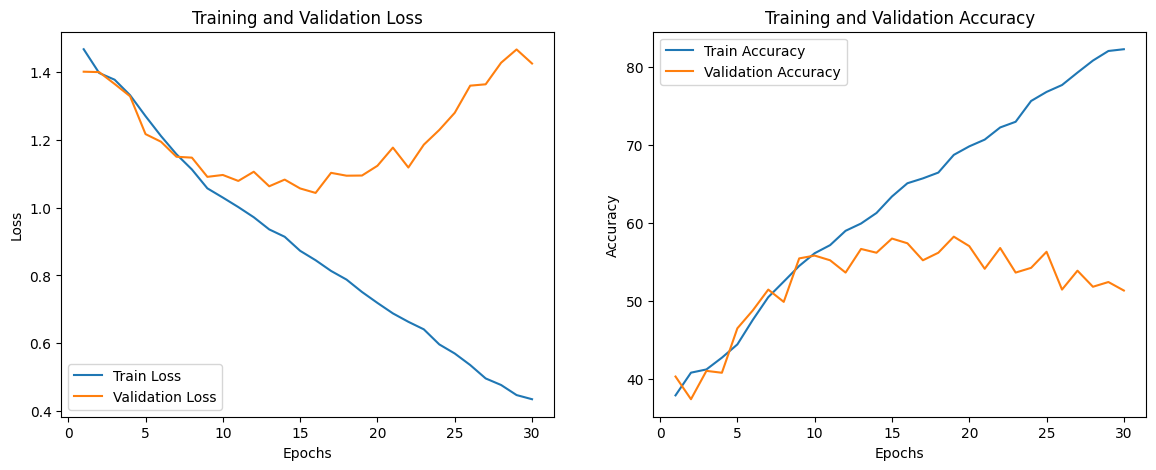

In [21]:

# Main Training Loop with Validation
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}', 
            'Accuracy': f'{100 * correct / total:.2f}%'
        })
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Call the plotting function
plot_training_curves(
    epochs_range=range(1, num_epochs + 1), 
    train_losses=train_losses, 
    val_losses=val_losses, 
    train_accuracies=train_accuracies, 
    val_accuracies=val_accuracies
)


# EVALUATION

Evaluation: 100%|██████████| 52/52 [00:05<00:00, 10.02batch/s]


Validation Accuracy: 55.25%


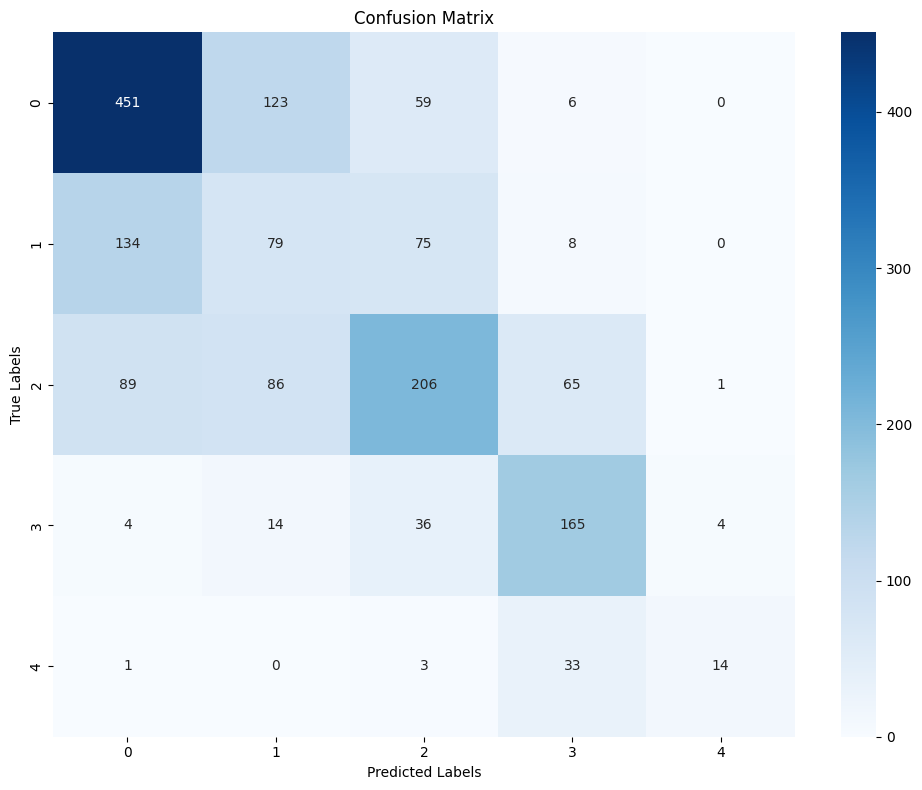

In [22]:

# Evaluation
model.eval()
val_correct = 0
val_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluation", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
        
        # Collect predictions and true labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, train_dataset.classes)